# TP 2-3 : Branch-and-bound applied to a knapsack problem

## Initialisation (à faire une seule fois)

In [ ]:
import Pkg;
Pkg.add("GraphRecipes");
Pkg.add("Plots");
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

## Récupération des données

In [2]:
"""Open and read a KnapFile.

Args: \\
    - filename (String): the name of the file to read.

Returns: \\
    - price (Vector{Integer}): prices of items to put in the KnapSack. \\
    - weight (Vector{Integer}): weights of items to put in the KnapSack. \\
    - capacity (Integer): the maximum capacity of the KnapSack.
"""
function readKnapInstance(filename)
    price = []
    weight = []
    capacity = -1
    open(filename) do f
        for i = 1:3
            tok = split(readline(f))
            if (tok[1] == "ListPrices=")
                for i = 2:(length(tok)-1)
                    push!(price, parse(Int64, tok[i]))
                end
            elseif (tok[1] == "ListWeights=")
                for i = 2:(length(tok)-1)
                    push!(weight, parse(Int64, tok[i]))
                end
            elseif (tok[1] == "Capacity=")
                capacity = parse(Int64, tok[2])
            else
                println("Unknown read :", tok)
            end
        end
    end
    return price, weight, capacity
end

readKnapInstance

In [3]:
# # on convert tous les .opb en .lp pour les utiliser dans glpk
# for (root, dirs, files) in walkdir("data")
#     for file in files
#         if endswith(file, ".opb")
#             price, weight, capacity = readKnapInstance(root * "/" * file)
#             filename = splitext(file)[1]
#             f = open(root * "/" * filename * ".lp", "w");
#             write(f, "Maximize\n")
#             write(f, "  Knap: ")
#             for (i, p) in enumerate(price)
#                 write(f, "+ " * string(p) * " obj" * string(i) * " ")
#             end
#             write(f, "\n")

#             write(f, "\nSubject To\n")
#             write(f, "  MaxKnap: ")
#             for (i, w) in enumerate(weight)
#                 write(f, "+ " * string(w) * " obj" * string(i) * " ")
#             end
#             write(f, "<= " * string(capacity) * "\n")

#             write(f, "\nBinary\n")
#             for (i, p) in enumerate(price)
#                 write(f, "  obj" * string(i) * "\n")
#             end

#             write(f, "\nEnd\n")
#             close(f)
#         end
#     end
# end

## Procédure d'application des tests de sondabilités TA, TO et TR pour le cas de la relaxation linéaire

In [4]:
"""Test if a node should be pruned.

Args: \\
    - x (Vector{Integer}): the node to be tested. \\
    - price (Vector{Integer}): prices of items to put in the KnapSack. \\
    - weight (Vector{Integer}): weights of items to put in the KnapSack. \\
    - capacity (Integer): the maximum capacity of the KnapSack. \\
    - BestProfit (Integer): the current BestProfit value. \\
    - Bestsol (Integer): the current BestSol values. \\
    - affich (Bool): determine if the function should print to stdout.

Returns: \\
    - TA (Bool): true if the node is feasible. \\
    - TO (Bool): true if the node is optimal. \\
    - TR (Bool): true if the node is resolvable. \\
    - BestProfit (Integer): the updated value of BestProfit. \\
    - Bestsol (Vector{Integer}): the updated values of BestSol.
"""
function TestsSondabilite(x, price, weight, capacity, BestProfit, Bestsol, affich)
    TA, TO, TR = false, false, false

    if (!Constraints(x, weight, capacity)) # Test de faisabilite
        TA = true
        if affich
            println("TA\n")
        end

    elseif (Objective(x, price) <= BestProfit) # Test d'optimalite
        TO = true
        if affich
            println("TO\n")
        end

    elseif (AllDef(x)) # Test de resolution
        TR = true
        if affich
            println("TR : solution ", " de profit ", Objective(x, price), "\n")
        end
        if (Objective(x, price) >= BestProfit) # Le profit de la solution trouvée est meilleur que les autres
            if affich
                println("\t-> Cette solution a un meilleur profit.\n")
            end
            # On remplace la solution et le profit par les nouvelles valeurs
            Bestsol = x
            BestProfit = Objective(x, price)
        else
            if affich
                println("\t-> Cette solution est moins bonne.\n")
            end
        end

    elseif affich
        println("non sondable\n")
    end

    return TA, TO, TR, Bestsol, BestProfit
end

TestsSondabilite

## Procédure de séparation et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [5]:
"""Split a node in two.

Args: \\
    - price (Vector{Integer}): prices of items to put in the KnapSack. \\
    - listvars (Vector{Vector{Integer}}): the current values of listvars. \\
    - listvals (Vector{Integer}): the current values of listvals.

Returns: \\
    - listvars (Vector{Vector{Integer}}): the updated values of listvars. \\
    - listvals (Vector{Integer}): the updated values of listvals.
"""
function SeparerNoeud(price, listvars, listvals)
    # Le noeud est non-sondable. Appliquer le critère de séparation pour le séparer en sous-noeuds 

    # Cas du noeud le plus à gauche

    # On sépare le noeud actuel en 2 sous-noeuds
    predX = pop!(listvars)
    nextX0 = copy(predX)
    nextX1 = copy(predX)

    # On initialise leurs valeurs à zéro
    val0 = 0
    val1 = 0

    # On fixe la nouvelle variable des deux sous-noeuds
    n = length(predX)
    for i = 1:n
        if predX[i] == -1
            # L'un a zéro
            nextX0[i] = 0
            # L'autre a un
            nextX1[i] = 1

            # On calcule leurs valeurs
            val0 = Objective(nextX0, price)
            val1 = Objective(nextX1, price)
            break
        end
    end
    
    # On ajoute les sous-noeuds a la pile des noeuds a explorer
    push!(listvars, nextX0)
    push!(listvars, nextX1)

    # On ajoute aussi leurs valeurs
    push!(listvals, val0)
    push!(listvals, val1)

    return listvars, listvals
end

SeparerNoeud

In [6]:
"""Pop node fom the list to explore another node.

Args: \\
    - price (Vector{Integer}): prices of items to put in the KnapSack. \\
    - listvars (Vector{Vector{Integer}}): the current values of listvars. \\
    - listvals (Vector{Integer}): the current values of listvals.

Returns: \\
    - listvars (Vector{Vector{Integer}}): the updated values of listvars. \\
    - listvals (Vector{Integer}): the updated values of listvals. \\
    - stop (Bool): true if the tree search is finished.
"""
function ExplorerAutreNoeud(listvars, listvals)
    # Le noeud est sondable, on l'enlève de la pile des noeuds à sonder

    stop = false
    if (length(listvars) > 1)
        # On passe au noeud suivant
        var = pop!(listvars)
        val = pop!(listvals)
    else
        # Il n'y a pas d'autre noeud
        stop = true
    end

    return listvars, listvals, stop
end

ExplorerAutreNoeud

## Fonctions décrivant l'objectif et les contraintes

In [7]:
# Fonction objectif que l'on souhaite maximiser/minimiser (évalué dans le meilleur des cas)
Objective(x, price) =
    sum(
        if x[i] < 0
            price[i]
        else
            price[i] * x[i]
        end
        for i = 1:length(x)
    )

# Fonction permettant de vérfier toutes les contraintes du modèle (dans le meilleur des cas)
Constraints(x, weight, capacity) =
    sum(
        if x[i] < 0
            0
        else
            weight[i] * x[i]
        end
        for i = 1:length(x)
    ) <= capacity

# Fonction qui nous dis si toutes les variables de x sont fixées
function AllDef(x)
    for i = 1:length(x)
        if x[i] < 0
            return false
        end
    end
    return true
end

AllDef (generic function with 1 method)

## Résolution du problème KnapSack

In [8]:
"""Solve the KnapSack problem for the data contained in `filename`.

Args: \\
    - filename (String): the name of the file to read.

Returns: \\
    - trParentnodes (Vector{Integer}): the parents nodes, to plot the tree.
    - trChildnodes (Vector{Integer}): the child nodes, to plot the tree.
    - trNamenodes (Vector{Integer}): the name of the nodes, to plot the tree.
"""
function SolveKnapInstance(filename)

    stop = false
    affich = true

    # Extraction des données
    price, weight, capacity = readKnapInstance(filename)

    tri = true
    if tri
        couples = zip(price, weight)
        couples = sort(collect(couples), by = x -> x[1] / x[2])
        unzip(a) = map(x->getfield.(a, x), fieldnames(eltype(a)))
        price, weight = unzip(couples)
    end

    expected = split(split(filename, "-")[2], ".")[1]
    nodes_nb = length(price)
    nodes_max = 2^nodes_nb

    if affich
        println("---", filename, "---")
        println("Capacity = ", capacity)
        println("Number of objects = ", nodes_nb)
        println("Expected optimal value = ", expected)
        println("Maximum number of nodes = ", nodes_max)
        println()    end

    # Pour dessiner le graph
    trParentnodes = Int64[]
    trChildnodes = Int64[]
    trNamenodes = []

    # Liste des variable pour naviguer de noeuds en noeuds
    listvars = []
    listvals = []
    listnodes = []

    # La meilleur solution et sa valeur
    BestProfit = -1
    Bestsol = []

    # Compter le nombre de noeud explorés
    current_node_number = 0

    # On ajoute le premier noeud à explorer (la racine)
    push!(listvars, [-1 for p in price])
    push!(listvals, Objective(last(listvars), price))
    push!(listnodes, 1)
    push!(trNamenodes, 0)
    newnodeid = 2

    while (!stop)

        # Le noeud actuel
        x = last(listvars)

        if affich && current_node_number % 10000 == 0
            println("Node n°", current_node_number, ": \tBestProfit = ", BestProfit)
            LastBestProfit = BestProfit
        end

        # Test de sondabilité du noeud actuel
        #   -> On mets a jour la solution et sa valeur si besoin
        TA, TO, TR, Bestsol, BestProfit = TestsSondabilite(x, price, weight, capacity, BestProfit, Bestsol, false)

        is_node_sondable = TA || TO || TR
        if (!is_node_sondable)
            # Le noeud n'est pas sondable, on le sépare en 2 sous-noeuds
            listvars, listvals = SeparerNoeud(price, listvars, listvals)

            curnode = pop!(listnodes)

            push!(trParentnodes, curnode)
            push!(trParentnodes, curnode)

            push!(listnodes, newnodeid + 1)
            push!(listnodes, newnodeid)

            push!(trChildnodes, newnodeid)
            push!(trChildnodes, newnodeid + 1)

            push!(trNamenodes, newnodeid - 1)
            push!(trNamenodes, newnodeid)

            newnodeid += 2

        else
            # Le noeud est sondable, on passe au noeud suivant
            listvars, listvals, stop = ExplorerAutreNoeud(listvars, listvals)

            pop!(listnodes)
        end

        current_node_number += 1
    end

    println("\n--------------------------------------------------")
    println("Expected optimal value = ", expected)
    println("Optimal value = ", BestProfit)
    println("Optimal x = ", Bestsol)
    println("Maximum number of nodes = ", nodes_max)
    println("Nodes explored = ", current_node_number)    
    
    return trParentnodes, trChildnodes, trNamenodes
end

SolveKnapInstance

In [9]:
trParentnodes, trChildnodes, trNamenodes = SolveKnapInstance("data/test-65.opb")

---data/test-65.opb---
Capacity = 10
Number of objects = 4
Expected optimal value = 65
Maximum number of nodes = 16

Node n°0: 	BestProfit = -1

--------------------------------------------------
Expected optimal value = 65
Optimal value = 65
Optimal x = [0, 1, 0, 1]
Maximum number of nodes = 16
Nodes explored = 23


([1, 1, 2, 2, 4, 4, 7, 7, 5, 5  …  3, 3, 14, 14, 17, 17, 15, 15, 20, 20], [2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  14, 15, 16, 17, 18, 19, 20, 21, 22, 23], Any[0, 1, 2, 3, 4, 5, 6, 7, 8, 9  …  13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

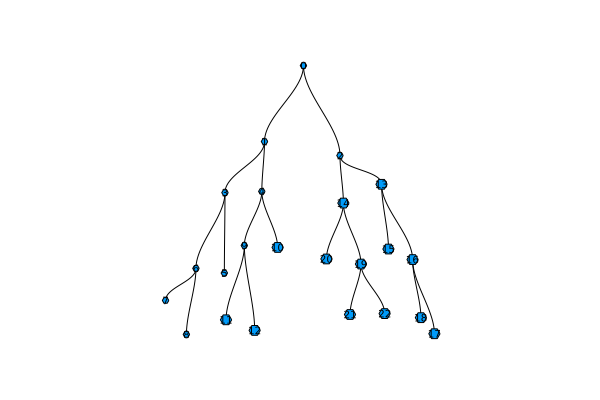

In [10]:
# graphplot(trParentnodes, trChildnodes, names = trNamenodes, method = :tree)

# Rapport

- Quelques détails sur les points clés et non triviaux de votre implémentation
- Une courte argumentation de l’adéquation du résultat avec l’instance résolue
- Quelques éléments d’analyse, par exemple :
- Analyser l’impact des différents paramètres de la PSE sur la performance en terme de vitesse/délais (en temps cpu et nombre de noeuds explorés) pour l’obtention d’une solution réalisable, pour l’obtention de la meilleure solution, pour l’obtention de bornes supérieures de qualité et pour la complétion de l’algorithme

## Notre implémentation

Pour l'implémentation de notre `branch and bound`, nous avons gardé la même architecture que celle du sujet. Nous avons simplement ré-écrit les fonctions qui calculent la valeur objectif et la valeur de la capacité. \
Notre vecteur de décision $x$ est tel que $x\in\{-1,0,1\}^n$ avec $n$ le nombre d'objets disponibles. $1$ et $0$ représentent, respectivement, un objet pris ou non-pris. La valeur $-1$ représente un objet ou la décision n'a pas encore été faite. \
Dans la fonction `Objective`, si la valeur est a $-1$, on fait comme-ci elle était à $1$ pour calculer une borne supérieur. Dans la fonction `Constraints` les $-1$ sont concidérés comme des $0$ pour avoir une borne inférieur de notre problème. \

Pour l'exploration et la création de noeud, nous faisons une exploration des noeuds avec le plus de $1$ en premier. \
Lorsque nous arrivons sur un noeud, nous l'enlevons de la pile des noeuds. Nous calculons ensuite s'il est "trivial", s'il dépasse déjà l'une des bornes ou s'il est divisible.
- Dans le cas ou il est "trivial", nous calculons sa valeur et remplaçons la meilleure valeur si nécessaire.
- Dans le cas ou il dépasse une borne, nous l'abandonnons.
- Et enfin, si il est séparable, nous le séparons en deux en ajoutant la pile des noeuds les deux sous noeuds. Exemple : $[(0,-1,-1)]$ -> $[(0,0,-1) ; (0,1,-1)]$

## Justification de nos résultats

Notre algorithme trouve bien les solutions idéales. Pour le test `uncorrelated_span/knapPI_11_20_1000_1_-1428` Nous avons trouvé la valeur optimale qui est de `1428` en `2131` exploration de noeuds là ou un algorithme classique de parcours de l'ensemble des noeuds aurait exploré `1048576` noeuds, et ce sans dépasser la capacité maximale du sac bien evidemment.

## Analyse

Nous avaons réalisé les calculs de deux manières différentes:
- La première fois, nous mettions a jour les coordonnées de $x$ dans l'ordre des indices.
- La deuxième fois, nous avons d'abbord trié les vecteurs `weight` et `price` par leur rapport $prix / poids$. Cela revient à mettre à jour les coordonnées de $x$ dans l'ordre du meilleur rapport $prix / poids$. (NB : le vecteur résultat n'est pas ré-ordonné comme l'était les `price` et `weight` initialement)

Pour le fichier `weakly_correlated/knapPI_2_50_1000_1_-1396`, nous avons comparé les résultats :
| Valeurs        | Sans tri | Avec tri |
| :------------- | :------- | :------- |
| Optimal value  | 1396     | 1396     |
| Nodes explored | 3053865  | 846447   |
| time           | 29.372s  | 4.480s   |

Il serait possible d'optimiser encore plus notre algorithme en ne stockant que les changements de valeurs dans l'abre, au lieu de stocker le vecteurs $x$ en entier à chaque noeud de l'arbre. Cela permetterait d'économiser pas mal de RAM.

## Bonus: Comparaison avec GLPK

La huitième cellule de ce notebook permet de convertir les `.opb` en `.lp`, et permet ainsi de résoudre les problèmes en utilisant GLPK.
Via les fichiers `test.jl` et `distrib.py` on lance sur toutes les machines de l'enseeiht (la nuit), la résolution de chaque problème via GLPK et via notre implémentation. On observe alors que GLPK obtient la même valeur optimale finale que notre implémentation, cependant le nombre de noeuds explorés par GLPK ainsi que son temps d'exécution sont nettement inférieur à ceux de notre algorithme.